In [1]:
# Design Exercises

In [1]:
# imports
import os, pandas as pd
import seaborn as sns

# variables
df_info_path = os.path.join(
    "/aloy",
    "home",
    "ddalton",
    "projects",
    "disease_signatures",
    "data",
    "DiSignAtlas",
    "Disease_information_Datasets_extended.csv",
)

# functions

# Load Data


df_info = pd.read_csv(df_info_path)

In [2]:
import xml.etree.ElementTree as ET, os

mesh_file_path = os.path.join(
    "/aloy/home/ddalton/projects/disease_signatures/data/MeSH/desc2023.xml"
)


# functions
def parse_mesh_data(file_path):
    """Parse MeSH XML data and extract disease terms."""
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract disease terms
    disease_terms = list()
    list_tree_numbers = list()
    for descriptor in root.findall("DescriptorRecord"):
        # Check if the term is under the category of diseases
        tree_numbers = descriptor.findall("TreeNumberList/TreeNumber")
        for tree_number in tree_numbers:
            # This is a basic check for TreeNumbers starting with 'C' which usually denotes diseases in MeSH
            # You might need to adjust this based on the specific structure of your XML file
            if tree_number.text.startswith("C"):
                list_tree_numbers.append(tree_number.text)
                term = descriptor.find("DescriptorName/String").text
                disease_terms.append(term)
                break  # Break after adding the term to avoid duplicates

    return disease_terms, list_tree_numbers


disease_terms, list_tree_numbers = parse_mesh_data(file_path=mesh_file_path)
print(disease_terms)

['Abdomen, Acute', 'Abdominal Injuries', 'Abdominal Neoplasms', 'Abetalipoproteinemia', 'Congenital Abnormalities', 'Abnormalities, Drug-Induced', 'Abnormalities, Multiple', 'Abnormalities, Radiation-Induced', 'Abortion, Spontaneous', 'Abortion, Habitual', 'Abortion, Incomplete', 'Abortion, Missed', 'Abortion, Septic', 'Abortion, Threatened', 'Abortion, Veterinary', 'Abruptio Placentae', 'Abscess', 'Peritonsillar Abscess', 'Acantholysis', 'Acanthosis Nigricans', 'Severe Acute Malnutrition', 'Shellfish Hypersensitivity', 'Symptom Flare Up', 'Obesity, Metabolically Benign', 'Cold Injury', 'War-Related Injuries', 'Late Onset Disorders', 'Compassion Fatigue', 'Fractures, Multiple', 'Drug Resistant Epilepsy', 'Autoimmune Hypophysitis', 'Canaliculitis', 'Incisional Hernia', 'Plasmablastic Lymphoma', 'Mammary Analogue Secretory Carcinoma', 'Acne Conglobata', 'Fused Kidney', 'Long Term Adverse Effects', 'Infectious Encephalitis', 'Waterborne Diseases', 'Unilateral Breast Neoplasms', 'Degloving

In [6]:
library_stratergies = ["RNA-Seq", "Microarray"]

QUERY = f"library_strategy in @library_stratergies"
df_filtered = df_info.query(QUERY)

print(df_filtered.shape, df_info.shape)

n_datasets_rnaseq = list()
n_datasets_microarray = list()
n_datasets = list()

disease_names = list()
for disease in df_filtered["disease"].unique():
    df_query = df_filtered.query(f'disease == "{disease}"')
    if df_query["accession"].nunique() > 0:
        n_datasets_rnaseq.append(
            df_query[df_query["library_strategy"] == "RNA-Seq"]["accession"].nunique()
        )
        n_datasets_microarray.append(
            df_query[df_query["library_strategy"] == "Microarray"][
                "accession"
            ].nunique()
        )
        n_datasets.append(df_query["accession"].nunique())


data_results = list()
for filter in range(1, 11):
    n_dis_count_rnaseq = len([x for x in n_datasets_rnaseq if x >= filter])
    n_dis_count_microarray = len([x for x in n_datasets_microarray if x >= filter])
    n_dis_count = len([x for x in n_datasets if x >= filter])

    data_results.append(
        {
            "Filter": f"Nº datasets ≥ {filter}",
            "Nº Diseases RNA-Seq": n_dis_count_rnaseq,
            "Nº Diseases Microarray": n_dis_count_microarray,
            "Nº Diseases RNA-Seq + Microarray": n_dis_count,
        }
    )

df_results = pd.DataFrame(data_results)
df_results

(9978, 14) (10306, 14)


,Filter,Nº Diseases RNA-Seq,Nº Diseases Microarray,Nº Diseases RNA-Seq + Microarray
0,Nº datasets ≥ 1,936,1272,1799
1,Nº datasets ≥ 2,297,436,638
2,Nº datasets ≥ 3,164,256,380
3,Nº datasets ≥ 4,117,196,275
4,Nº datasets ≥ 5,87,143,218
5,Nº datasets ≥ 6,69,120,181
6,Nº datasets ≥ 7,59,98,154
7,Nº datasets ≥ 8,52,84,139
8,Nº datasets ≥ 9,41,73,119
9,Nº datasets ≥ 10,38,69,104


In [7]:
## Exercise 1: Small Dataset

In [8]:
## Exercise 2: Medium Dataset

In [29]:
"""Exercise 2: Medium Dataset

Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Filter Data
    4. Analysis
"""

# 1. Imports, Variables and Functions
# imports
from typing import *
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

# variables
library_stratergies = ["RNA-Seq", "Microarray"]


# functions
def get_diseases_n_datasets(df: pd.DataFrame, n: int = 10) -> List:
    """Get Diseases With More Than n Datasets

    Args:
        - df(pd.DataFrame): DataFrame with the information
        - diseases(List): List of diseases to filter
        - n(int): Number of datasets to filter

    Returns:
        - List: List of diseases with more than n datasets
    """
    diseases_list = list()
    dsaids_list = list()
    # iterate over diseases
    for disease in df["disease"].unique():
        df_query = df.query(f'disease == "{disease}"')
        if df_query["accession"].nunique() >= n:
            diseases_list.append(disease)
            dsaids_list.append(df_query["dsaid"].unique())

    return diseases_list, dsaids_list

def get_medium_dataset(df: pd.DataFrame, n: int = 10) -> pd.DataFrame:
    """Get Medium Dataset

    Args:
        - df(pd.DataFrame): DataFrame with the information
        - n(int): Number of datasets to filter

    Returns:
        - pd.DataFrame: DataFrame with the medium dataset
    """
    # load mappings dsaids -> MeSH terms
    mesh_terms = pickle.load(
        open(
            "/aloy/home/ddalton/projects/disease_signatures/data/DiSignAtlas/mesh_tree_terms.pkl",
            "rb",
        )
    )

    dsaid_2_mesh = {
        k: v for k, v in zip(mesh_terms["dsaids"], mesh_terms["mesh_tree_terms"])
    }

    dsaids_with_mesh = [k for k, v in dsaid_2_mesh.items() if len(v) > 0]
    
    
    # filter by nº of datasets
    diseases_list, dsaids_list = get_diseases_n_datasets(df, n)

    # filter by MeSH term presence
    diseases_f_mesh = list()
    dsaids_f_mesh = list()
    for disease_i, dsaids_i in tqdm(zip(diseases_list, dsaids_list),total=len(diseases_list)):
        
        if np.isin(dsaids_i, dsaids_with_mesh).any():
            diseases_f_mesh.append(disease_i)
            for dsaid_j in dsaids_i:
                if dsaid_j in dsaids_with_mesh:
                    dsaids_f_mesh.append(dsaid_j)
                else:
                    logging.info("DSAID of a disease w/ other DSAID w/ MeSH terms - but it itself doesn't have MeSH terms")
                    logging.info(f"{dsaid_j}, {disease_i}")
                                    
    logging.info(f"Nº of diseases {len(diseases_f_mesh)}/{len(diseases_list)}")             
    logging.info(f"Nº of dsaids {len(dsaids_f_mesh)}/{len([x for sublist in dsaids_list for x in sublist])}")             
    return diseases_f_mesh, dsaids_f_mesh

# 2. Load Data
# get df 

QUERY = f"library_strategy in @library_stratergies"
df_filtered = df_info.query(QUERY)



# load MeSH tree


# load mappings dsaids -> MeSH terms
mesh_terms = pickle.load(
    open(
        "/aloy/home/ddalton/projects/disease_signatures/data/DiSignAtlas/mesh_tree_terms.pkl",
        "rb",
    )
)

dsaid_2_mesh = {
    k: v for k, v in zip(mesh_terms["dsaids"], mesh_terms["mesh_tree_terms"])
}

dsaids_with_mesh = [k for k, v in dsaid_2_mesh.items() if len(v) > 0]

# 3. Filter Data


# filter by nº of datasets
diseases_list, dsaids_list = get_diseases_n_datasets(df_filtered, 10)

# filter by MeSH term presence
diseases_f_mesh = list()
dsaids_f_mesh = list()
for disease_i, dsaids_i in tqdm(zip(diseases_list, dsaids_list),total=len(diseases_list)):
    
    if np.isin(dsaids_i, dsaids_with_mesh).any():
        diseases_f_mesh.append(disease_i)
        for dsaid_j in dsaids_i:
            if dsaid_j in dsaids_with_mesh:
                dsaids_f_mesh.append(dsaid_j)
            else:
                logging.info("DSAID of a disease w/ other DSAID w/ MeSH terms - but it itself doesn't have MeSH terms")
                logging.info(dsaid_j, disease_i)
                                
                    
logging.info(len(diseases_f_mesh), len(dsaids_f_mesh))

# 4. Analysis

2024-10-06 16:13:28,770 - DSAID of a disease w/ other DSAID w/ MeSH terms - but it itself doesn't have MeSH terms
--- Logging error ---
Traceback (most recent call last):
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/runpy.py",

In [30]:
# filter df by library strategy
df_filtered = df_info.query(QUERY)

# get dsaids of interest

diseases_interest, dsaids_interest = get_medium_dataset(df_filtered, 10)

2024-10-06 16:13:31,891 - DSAID of a disease w/ other DSAID w/ MeSH terms - but it itself doesn't have MeSH terms
--- Logging error ---
Traceback (most recent call last):
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/runpy.py",

In [28]:
dsaids_interest

['DSA00006',
 'DSA00875',
 'DSA01135',
 'DSA02467',
 'DSA02468',
 'DSA02469',
 'DSA02470',
 'DSA02471',
 'DSA02472',
 'DSA05181',
 'DSA05182',
 'DSA05183',
 'DSA06091',
 'DSA06997',
 'DSA07000',
 'DSA07442',
 'DSA07444',
 'DSA07445',
 'DSA07447',
 'DSA08781',
 'DSA09423',
 'DSA00028',
 'DSA00029',
 'DSA00483',
 'DSA00484',
 'DSA00485',
 'DSA00486',
 'DSA00667',
 'DSA00900',
 'DSA01954',
 'DSA02381',
 'DSA02777',
 'DSA03285',
 'DSA03979',
 'DSA03994',
 'DSA06934',
 'DSA06936',
 'DSA08047',
 'DSA08311',
 'DSA08753',
 'DSA08754',
 'DSA08760',
 'DSA09934',
 'DSA00030',
 'DSA00457',
 'DSA00458',
 'DSA00480',
 'DSA01206',
 'DSA01207',
 'DSA01469',
 'DSA01470',
 'DSA01471',
 'DSA01472',
 'DSA01473',
 'DSA01731',
 'DSA01737',
 'DSA01739',
 'DSA01745',
 'DSA01754',
 'DSA01821',
 'DSA01822',
 'DSA01989',
 'DSA01990',
 'DSA02259',
 'DSA02260',
 'DSA02261',
 'DSA02279',
 'DSA02407',
 'DSA02408',
 'DSA02943',
 'DSA02945',
 'DSA03191',
 'DSA03192',
 'DSA03193',
 'DSA03194',
 'DSA03373',
 'DSA03386',

NameError: name 'studies' is not defined

In [55]:
mesh_i

[['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113.500'],
 ['F03.625.164.113.500'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113'],
 ['F03.625.164.113']]

Text(0, 0.5, 'Number of Diseases')

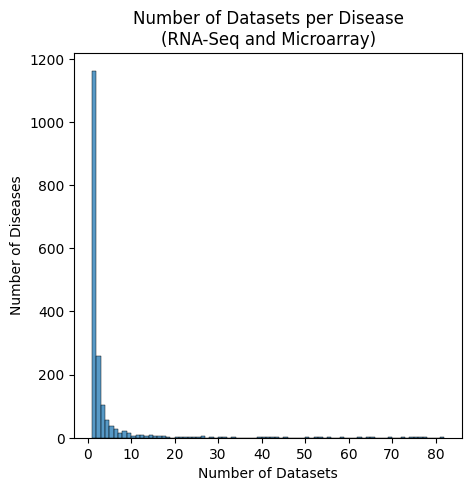

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
sns.histplot(n_datasets, binwidth=1)

plt.title("Number of Datasets per Disease\n(RNA-Seq and Microarray)")
plt.xlabel("Number of Datasets")
plt.ylabel("Number of Diseases")

In [ ]:
## Exercise 3: Large Dataset

In [ ]:
## Test area

In [ ]:
def get_expr_dsaids(dsaids:List)->pd.DataFrame:
    """Get expression data for a list of dsaids.
    Args:
        - dsaids(List): List of dsaids to get expression data
    Returns:
        - pd.DataFrame: DataFrame with expression data
    """
    pass
    

In [ ]:
import networkx as nx

import matplotlib.pyplot as plt


# Create a graph

G = nx.Graph()


# Add edges to the graph based on shared MeSH terms for each study

for study in studies:

    # Fully connect the MeSH terms of each study

    for i in range(len(study)):

        for j in range(i + 1, len(study)):

            G.add_edge(study[i], study[j])


# Draw the graph

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    font_size=8,
    node_size=2000,
    edge_color="gray",
)

plt.title("Graph Representation of MeSH Terms Across Studies")

plt.show()


# Function to compute the shortest path between two studies based on MeSH terms


def compute_shortest_path(study1, study2):

    # Find shortest path between any two MeSH terms from study1 and study2

    shortest_path = None

    for term1 in study1:

        for term2 in study2:

            if nx.has_path(G, term1, term2):

                path = nx.shortest_path(G, source=term1, target=term2)

                if shortest_path is None or len(path) < len(shortest_path):

                    shortest_path = path

    return shortest_path


# Example: Compute the shortest path between study 0 and study 4

study1 = studies[0]

study2 = studies[4]

shortest_path = compute_shortest_path(study1, study2)

shortest_path

In [19]:
manual_parameters = { 
    "dataset_exercise":"medium",                 
    "diseases_of_interest_set": None,
    "library_strategies_of_interest_set": list({
        "Microarray"
    }),
}




# if dataset exercise
if manual_parameters.get("dataset"):
    if manual_parameters["dataset"] == "small":
        print("Small Dataset")

    elif manual_parameters["dataset"] == "medium":
        print("Medium Dataset")

    elif manual_parameters["dataset"] == "large":
        print("Large Dataset")

# if specific diseases
else:
    print(manual_parameters["diseases_of_interest_set"]) 

None
